In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, accuracy_score

/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

In [2]:
def pre_processing(df_original, feature_scaling=True):
    
    #
    # only works for numerical dataframe
    #

    df = df_original.copy()
    df = df.drop(range(0, 10))
    df.index = range(len(df.index))

    df['month_year'] = [str(i[1]) + '-' + str(i[0]) for i in df['date'].astype(str).apply(lambda x: x.split('-'))]

    df = df.drop(['date'], axis=1)

    # handling the missing values
    ########################################################################
    # handle when number of records with missing values are less than 1%
    if (df.isna().sum().sum()) * 100 / len(df) < 1:
        df.dropna(axis=0)

    # handle when entries in column with missing values are less than 50%
    for i in range(len(df.isna().sum())):
        if (df.isna().sum()[i]) * 100 / len(df) > 50:
            df.drop(df.isna().sum().index[i], inplace=True, axis=1)

    # imputation using mean for numerical values
    num_cols = df._get_numeric_data().columns

    for i in range(len(df.isna().sum())):
        if df.isna().sum().index[i] in num_cols:
            df[df.isna().sum().index[i]].fillna(value=df[df.isna().sum().index[i]].mean(), inplace=True, axis=1)

    # return the updated dataframe

    # Feature scaling on numerical data
    ##########################################################################
    #
    if feature_scaling:
        for i in df.columns.tolist():
            if i != 'month_year':
                df[i] = df[i].apply(lambda x: (x - df[i].mean()) / df[i].std())

    return df


def merger(datalist, common_column="month_year", how_param="left", drop_na=True):
    data = datalist[0]
    for i in range(len(datalist) - 1):
        data = pd.merge(data, datalist[i + 1], on=common_column, how=how_param)
    if drop_na:
        data = data.dropna()
    data = data.reset_index()
    data = data.drop("index", axis=1)
    
    return data

# Outlier detection and removal
###########################################################################
#
def DBScan(data, radius=0.3, min_points=10, avoid_col = None):

    X = data.copy()

    if avoid_col is not None:
        X = X.drop(avoid_col, axis=1)

    db = DBSCAN(eps=radius, min_samples=min_points).fit(X)
    core_points = np.zeros_like(db.labels_, dtype=bool)

    core_points[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Number of outliers
    n_noise = list(labels).count(-1)

    try:
        print("Number of clusters formed: ",n_clusters)
        print("Number of outliers(removed): ",n_noise)
        print("Silhouette Coefficient: %0.2f" % metrics.silhouette_score(X, labels))
        s_c = metrics.silhouette_score(X, labels)
        
    except:
        print("Problem in calculating Silhouette.")
        s_c = -1
    # Removing the outliers
    data= data[core_points]
    data = data.reset_index()
    data = data.drop("index", axis=1)
    
    ##############################################################################
    return data, s_c 


def covNcorr(Mat):
    '''
    Data matrix is required in the columns as attributes(features) and rows as records
    '''
    Mat= Mat.astype(np.float)
    r,c= Mat.shape
    Colstd= np.zeros(c).astype(np.float)
    #print("shape of the given matrix is (r,c):", r,c)
    for i in range(c):
        Mat.iloc[:,i]= Mat.iloc[:,i]- np.mean(Mat.iloc[:,i])
    for i in range(c):
        Colstd[i]= 1/(r-1) * np.sqrt(np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,i]))
    CovMat=np.zeros([c,c]).astype(np.float)
    CorrMat=np.zeros([c,c]).astype(np.float)
    for i in range(c):
        for j in range(c):
            CovMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j])
            CorrMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j]) / (Colstd[i]*Colstd[j])
    return CovMat, CorrMat

def PCA(Mat, IP=90, PCA_vectors=0, verbose = True):
    CovMat, CorrMat = covNcorr(Mat)
    
    if verbose:
        print('Correlation matrix\n###################################\n')
        print(CorrMat)
    
    e,v= np.linalg.eig(CovMat)
    df= pd.DataFrame([e,v]).transpose()
    df.columns=(["EigenValue","EigenVector"])
    dfsorted=df.sort_values(by= "EigenValue",ascending=False)
    eigenvalues_sorted= np.array(dfsorted["EigenValue"])
    eigenvectors_sorted= np.array(dfsorted["EigenVector"])

    sum_eigenvalues= np.sum(eigenvalues_sorted)
    eigen_temp_sum=0.0
    IP_calc= 0.0
    Transform_matrix= np.transpose(eigenvectors_sorted[0]).copy()
    i=0
    flag=1
    while flag:
        eigen_temp_sum= eigen_temp_sum+ eigenvalues_sorted[i]
        IP_calc= eigen_temp_sum/sum_eigenvalues *100
        if verbose:
            print("Adding Component No.", i+1)
        if i!=0:
            Transform_matrix = np.append(Transform_matrix,np.transpose(eigenvectors_sorted[i]))
        i=i+1
        if verbose:
            print("Information Retained = ", IP_calc)
        if PCA_vectors==0:
            if IP <= IP_calc or IP_calc==100:
                flag=0
        else:
            if i>=PCA_vectors or IP_calc==100:
                flag=0
    Ready_Transform_basis= np.transpose(Transform_matrix.reshape(i,eigenvectors_sorted[0].shape[0])).copy()
    if verbose:
        print(Ready_Transform_basis)
        print("Projected Data:")
    projected_data= np.dot(Mat,Ready_Transform_basis)
    if verbose:
        print(projected_data)

    information_Retained= IP_calc
   
    return Ready_Transform_basis, projected_data, information_Retained


def visualisatio_using_pca(features, target):
    
    
    Transformation_mat, projected_data, info_retainment = PCA(features,PCA_vectors=1, verbose=True)
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    plt.scatter(projected_data, target, color = 'green')
    plt.title('Visualisation of variance on 1st Principle Component')
    plt.ylabel('GDP')
    plt.xlabel('1st PC projection')
    plt.legend([str(round(info_retainment,2))+"% information of actual data"])
    plt.show()


def polynomial_regressor_fit(X, y, degree=2):

    polynomial_model = PolynomialFeatures(degree=degree)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    return regressor

In [3]:
#
# Data laoding
#

df_cpi = pd.read_excel("data/CPI_base2015_1960_2020_Monthly.xls", names=['date', 'CPI_value'])
df_export_g_s = pd.read_excel("data/Export_G&S_1996_2020_quart.xls", names=['date', 'Export_g_s_value'])
df_GFCE = pd.read_excel("data/GFCE_1996_2020_quart.xls", names=['date', 'GFCE_value'])
df_GFCF = pd.read_excel("data/GFCF_1996_2020_quart.xls", names=['date', 'GFCF_value'])
df_GDP = pd.read_excel("data/GDP_india_1997_2021.xls", names=['date', 'GDP_value'])
df_M1 = pd.read_excel("data/M1_1969_2020_Monthly.xls", names=['date', 'M1_value'])
df_M3 = pd.read_excel("data/M3_1960_2020_Monthly.xls", names=['date', 'M3_value'])
df_PFCE = pd.read_excel("data/PFCE_1996_2020_quart.xls", names=['date', 'PFCE_value'])
df_cpi.head(20)

,date,CPI_value
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fredhelp.stlouisfed.org,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,INDCPIALLMINMEI,"Consumer Price Index: All Items for India, Ind..."
7,NaN,NaN
8,Frequency: Monthly,NaN
9,observation_date,INDCPIALLMINMEI


In [4]:
#
#  Pre-processing
#

df_cpi = pre_processing(df_cpi)
df_export_g_s = pre_processing(df_export_g_s)
df_GFCE = pre_processing(df_GFCE)
df_GFCF = pre_processing(df_GFCF)
df_GDP = pre_processing(df_GDP, feature_scaling=False)
df_M1 = pre_processing(df_M1)
df_M3 = pre_processing(df_M3)
df_PFCE = pre_processing(df_PFCE)
#data = pd.merge(df_cpi, df_M1, on="month_year", how='left')
df_cpi.head(25)


,CPI_value,month_year
0,-0.857755,01-1960
1,NaN,02-1960
2,-0.858149,03-1960
3,-0.857755,04-1960
4,NaN,05-1960
5,-0.857064,06-1960
6,-0.856275,07-1960
7,-0.856275,08-1960
8,-0.856669,09-1960
9,-0.856669,10-1960


In [5]:
#
#  creating a common dataset
#

datalist = [df_cpi, df_export_g_s, df_GFCF, df_GFCE, df_M1, df_M3, df_PFCE, df_GDP]
data = merger(datalist, drop_na=True)

data

,CPI_value,month_year,Export_g_s_value,GFCF_value,GFCE_value,M1_value,M3_value,PFCE_value,GDP_value
0,-0.107924,04-1997,-1.118469,-1.120248,-0.996790,-0.380329,-0.428011,-1.014680,3.271867
1,-0.098937,07-1997,-1.119222,-1.117364,-0.993116,-0.377237,-0.424291,-1.006179,3.995211
2,-0.083210,10-1997,-1.110665,-1.108893,-0.979392,-0.377156,-0.418694,-1.000421,4.010855
3,-0.040523,01-1998,-1.113908,-1.104725,-0.916516,-0.371136,-0.413276,-0.991115,4.916954
4,-0.042770,04-1998,-1.103360,-1.095099,-0.911770,-0.352962,-0.401016,-0.979275,5.85828
...,...,...,...,...,...,...,...,...,...
92,2.506814,04-2020,1.054753,0.354731,2.535564,3.130820,3.004737,1.133394,-23.326772
93,2.579368,07-2020,1.603474,1.617637,1.682778,3.332501,3.129132,1.713926,-7.536831
94,2.664175,10-2020,1.663187,2.022513,1.948298,3.352060,3.166571,2.131849,0.015035
95,2.625366,01-2021,1.927843,2.383789,2.412360,3.609272,3.292296,2.262772,1.640605


In [9]:
#
# outlier removal
#

########################## checking which params can be better for DBSCAN ###################
mx_sc= -1
param_rad = 0
param_n_points = 0
for i in range(1,10,1):
    for j in range(2,10,1):
        print("radius: ", i/10, "points: ", j)
        temp, sc = DBScan(data, radius =i/10, min_points = j, avoid_col = "month_year")
        if mx_sc < sc:
            mx_sc = sc            
            param_rad = i/10
            param_n_points = j
            
print("Max Silhouett: ", mx_sc, "params: rad, min_points: ", param_rad, param_n_points)

############################# using DBSCAN with the suitable params ##########################
data, sc = DBScan(data, radius =0.7, min_points = 2, avoid_col = "month_year")

radius:  0.1 points:  2
Number of clusters formed:  3
Number of outliers(removed):  91
Silhouette Coefficient: -0.19
radius:  0.1 points:  3
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  4
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  5
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  6
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  7
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  8
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.1 points:  9
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.2 points:  2
Numbe

/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:737: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < LooseVersion('0.12'):
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:737: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < LooseVersion('0.12'):
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/devendra/anaconda3/lib/python3.7/site-packages

radius:  0.4 points:  8
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.4 points:  9
Number of clusters formed:  0
Number of outliers(removed):  97
Problem in calculating Silhouette.
radius:  0.5 points:  2
Number of clusters formed:  14
Number of outliers(removed):  35
Silhouette Coefficient: 0.11
radius:  0.5 points:  3
Number of clusters formed:  7
Number of outliers(removed):  49
Silhouette Coefficient: -0.02
radius:  0.5 points:  4
Number of clusters formed:  7
Number of outliers(removed):  52
Silhouette Coefficient: -0.07
radius:  0.5 points:  5
Number of clusters formed:  4
Number of outliers(removed):  68
Silhouette Coefficient: 0.01
radius:  0.5 points:  6
Number of clusters formed:  3
Number of outliers(removed):  74
Silhouette Coefficient: -0.04
radius:  0.5 points:  7
Number of clusters formed:  2
Number of outliers(removed):  83
Silhouette Coefficient: -0.14
radius:  0.5 points:  8
Number of clusters formed:  0
N

/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:737: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < LooseVersion('0.12'):
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:737: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < LooseVersion('0.12'):
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/devendra/anaconda3/lib/python3.7/site-packages

radius:  0.7 points:  9
Number of clusters formed:  1
Number of outliers(removed):  87
Silhouette Coefficient: -0.05
radius:  0.8 points:  2
Number of clusters formed:  10
Number of outliers(removed):  14
Silhouette Coefficient: -0.01
radius:  0.8 points:  3
Number of clusters formed:  7
Number of outliers(removed):  20
Silhouette Coefficient: -0.04
radius:  0.8 points:  4
Number of clusters formed:  5
Number of outliers(removed):  30
Silhouette Coefficient: 0.00
radius:  0.8 points:  5
Number of clusters formed:  2
Number of outliers(removed):  43
Silhouette Coefficient: 0.10
radius:  0.8 points:  6
Number of clusters formed:  2
Number of outliers(removed):  44
Silhouette Coefficient: 0.09
radius:  0.8 points:  7
Number of clusters formed:  4
Number of outliers(removed):  50
Silhouette Coefficient: 0.03
radius:  0.8 points:  8
Number of clusters formed:  4
Number of outliers(removed):  51
Silhouette Coefficient: 0.01
radius:  0.8 points:  9
Number of clusters formed:  3
Number of outl

/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/devendra/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/devendra/anaconda3/lib/python3.7/site-

In [10]:
#
#  data preparation
#

gdp= data['GDP_value']
features = data.drop(['GDP_value','month_year'], axis = 1)

train_features, test_features, train_res, test_res= train_test_split(features,gdp)

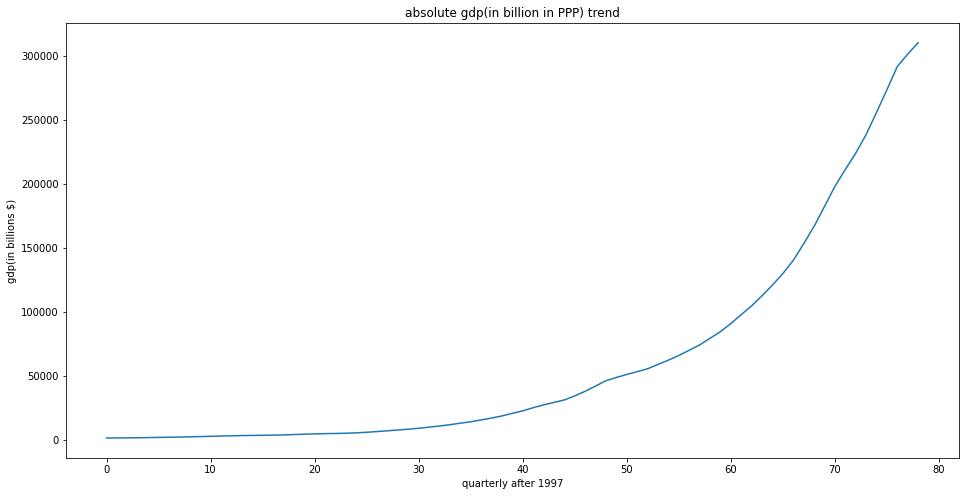

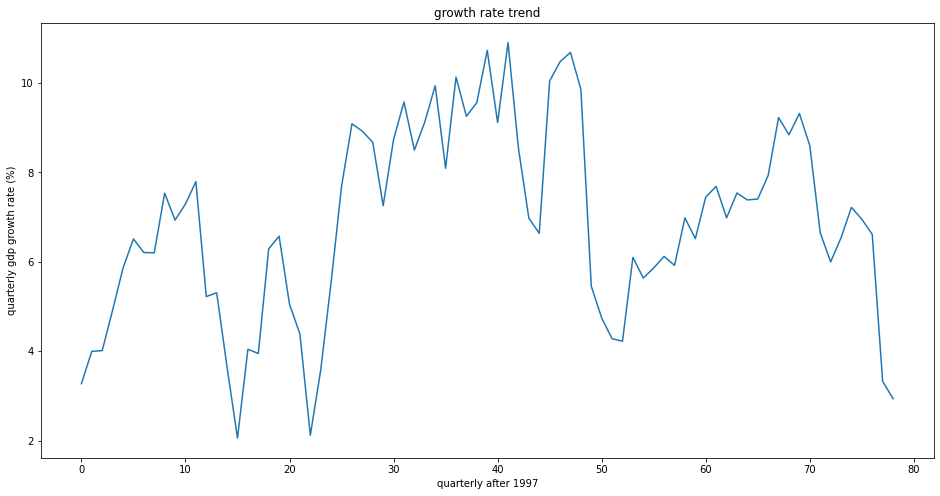

Correlation matrix
###################################

[[78.         77.05184821 77.35973036 75.81711702 77.25098961 77.71226875
  77.09415306]
 [77.05184821 78.         77.26769252 74.96631158 76.29455626 76.58050986
  75.63528248]
 [77.35973036 77.26769252 78.         75.78647669 77.58957055 77.47243256
  76.89862689]
 [75.81711702 74.96631158 75.78647669 78.         76.06695272 76.42148766
  76.52603076]
 [77.25098961 76.29455626 77.58957055 76.06695272 78.         77.72229871
  77.48651793]
 [77.71226875 76.58050986 77.47243256 76.42148766 77.72229871 78.
  77.74743034]
 [77.09415306 75.63528248 76.89862689 76.52603076 77.48651793 77.74743034
  78.        ]]
Adding Component No. 1
Information Retained =  98.71329779399686
[[ 0.33632382]
 [-0.15412367]
 [ 0.09104739]
 [-0.57426255]
 [-0.5793655 ]
 [-0.42582708]
 [ 0.08984428]]
Projected Data:
[[ 0.91795383]
 [ 0.91663305]
 [ 0.91158079]
 [ 0.88575096]
 [ 0.86683402]
 [ 0.88726745]
 [ 0.90373853]
 [ 0.87963289]
 [ 0.83792057]
 [ 0.8

/home/devendra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/devendra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/devendra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationW

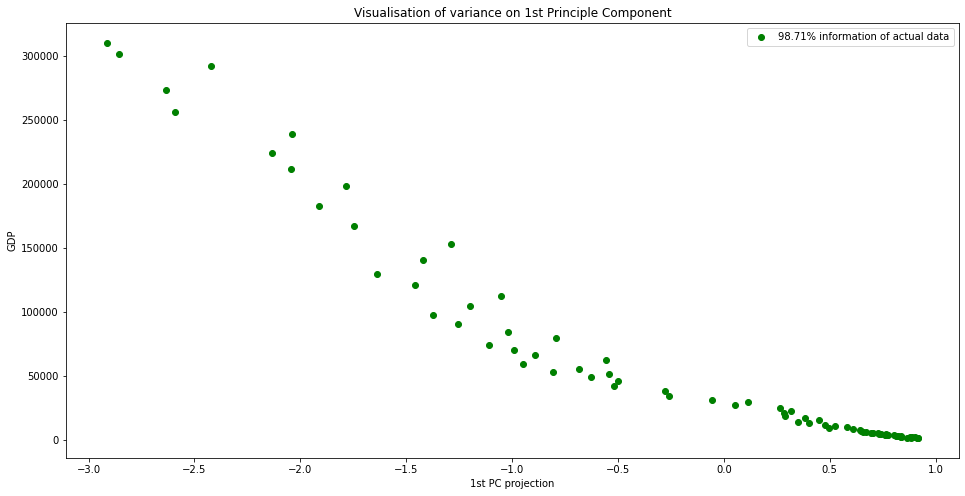

In [11]:
#
# Visualization of information in data
#

# calculation of absolute gdp after 19197 and its visulisation
gdp_actual_figure = 1653.1  # in billions$ in 1997 (PPP)
gdp_absolute = gdp.copy()

reference = gdp_actual_figure + gdp_actual_figure * gdp[0]/100

gdp_absolute[0] = reference

for i in range(len(gdp)-1):
    gdp_absolute[i+1] = reference + reference*gdp[i+1]/100
    reference = gdp_absolute[i+1]


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp_absolute)
plt.title('absolute gdp(in billion in PPP) trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('gdp(in billions $)')
plt.show()

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp)
plt.title('growth rate trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('quarterly gdp growth rate (%)')
plt.show()


visualisatio_using_pca(features, gdp_absolute)

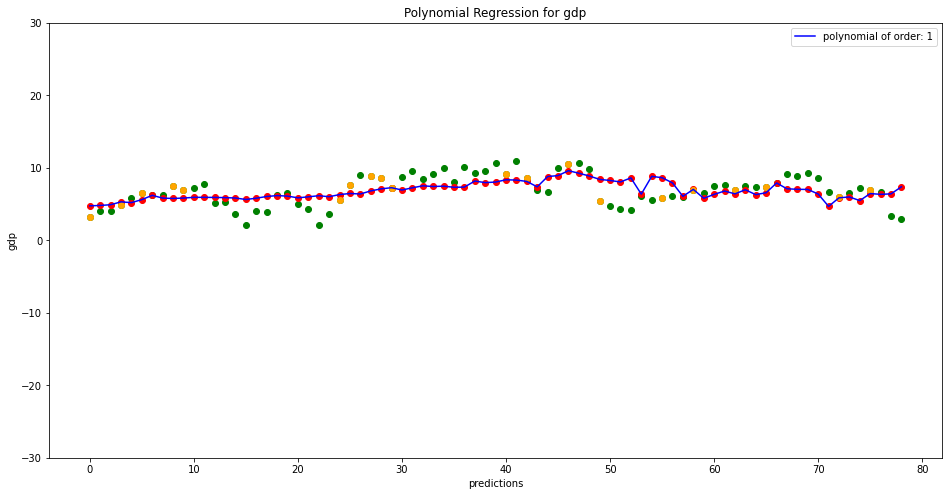

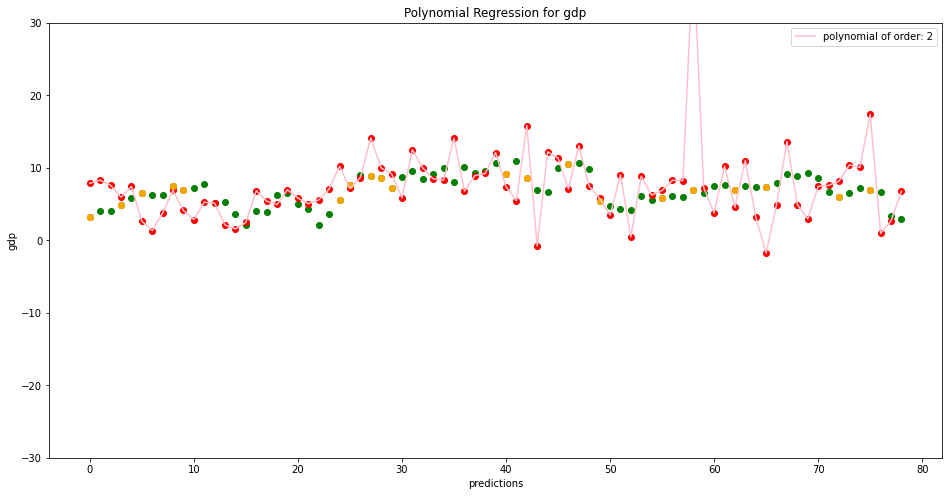

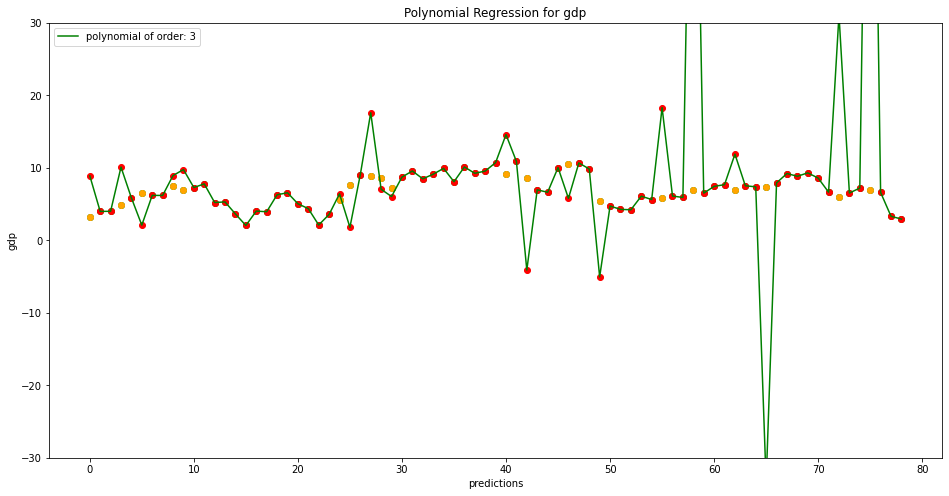

In [19]:
# spearmen corr needed
#  Modeling
#


colors = ['red', 'blue', 'pink', 'green', 'yellow']
for order in range(1,4):
    X = train_features
    y = train_res

    polynomial_model = PolynomialFeatures(degree=order)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    output = regressor.predict(polynomial_model.fit_transform(features))
    
    x_axis = np.array([i for i in range(len(output))])
    #x_axis_test = np.array([i for i in range(len(test_res))])

    #test = [test_res[i] if i in test_res.index else  for i in x_axis]
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.ylim([-30, 30])
    

    plt.scatter(x_axis, gdp, color = 'green')
    plt.scatter(x_axis, output, color = 'red')
    plt.scatter(test_res.index,test_res,color ='orange')

    
    
    plt.plot(x_axis, regressor.predict(polynomial_model.fit_transform(features)), color = colors[order])
    
    plt.legend(['polynomial of order: '+ str(order)])

    plt.title('Polynomial Regression for gdp')
    plt.xlabel('predictions')
    plt.ylabel('gdp')
 
    plt.show()

In [13]:
test_res

72     5.994043
9      6.929968
25     7.685049
65     7.401979
3      4.916954
49     5.452603
62     6.980694
58     6.978562
42     8.537632
28     8.669361
40     9.110817
75     6.948839
0      3.271867
46    10.471424
5      6.508867
24     5.546134
8      7.531356
55     5.860662
29     7.252543
27     8.918198
Name: GDP_value, dtype: object